自転車の現在地とホームポジションデータをランダムに生成

In [18]:
import pandas as pd
import numpy as np

# シード値を設定
np.random.seed(4)

# 自転車の位置情報をランダムに生成
num_positions = 5  # 5個の位置情報を生成
min_coord, max_coord = 0, 100  # 座標の範囲（0から100）
home_positions = [(np.random.randint(min_coord, max_coord), np.random.randint(min_coord, max_coord)) for _ in range(num_positions)]

# 現在地情報（座標）をランダムに生成
current_locations = [(np.random.randint(min_coord, max_coord), np.random.randint(min_coord, max_coord)) for _ in range(num_positions)]

# データフレームを作成
data = {
    'Home Position': home_positions,
    'Current Location': current_locations
}

df = pd.DataFrame(data)

# Current Location == Home Positionの場合のデータを追加
num_same_positions = 5
same_locations =[(np.random.randint(min_coord, max_coord), np.random.randint(min_coord, max_coord)) for _ in range(num_same_positions)]
new_row = pd.DataFrame({'Home Position': same_locations, 'Current Location': same_locations})
df = pd.concat([df, new_row], ignore_index=True)

df


,Home Position,Current Location
0,"(46, 55)","(55, 55)"
1,"(69, 1)","(57, 36)"
2,"(87, 72)","(50, 44)"
3,"(50, 9)","(38, 52)"
4,"(58, 94)","(3, 0)"
5,"(55, 21)","(55, 21)"
6,"(21, 73)","(21, 73)"
7,"(38, 56)","(38, 56)"
8,"(66, 46)","(66, 46)"
9,"(30, 8)","(30, 8)"


自転車の現在地とホームポジションまでの方向をプロット

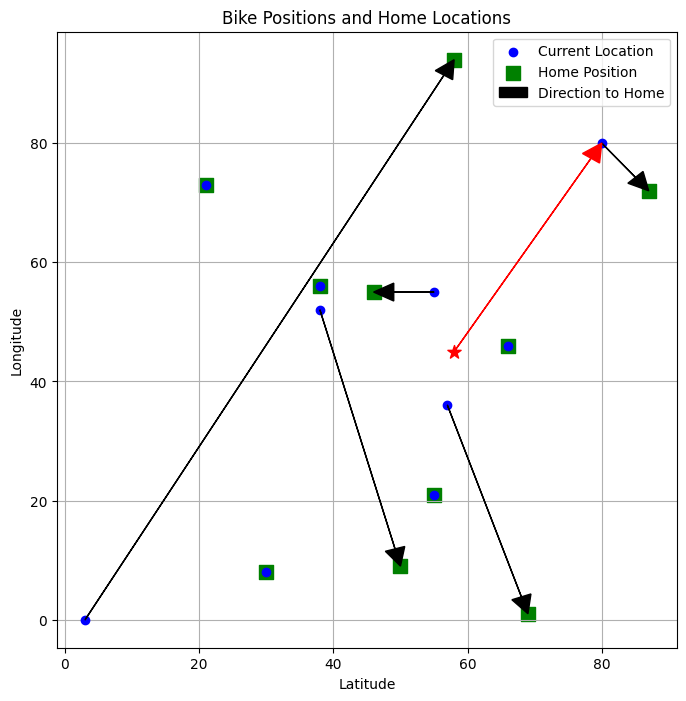

In [26]:
import matplotlib.pyplot as plt

# プロットを作成
plt.figure(figsize=(8, 8))
for index, row in df.iterrows():
    plt.scatter(row['Current Location'][0], row['Current Location'][1], marker='o', color='blue', zorder=2)  # 現在地をプロット
    plt.scatter(row['Home Position'][0], row['Home Position'][1], marker='s', color='green', s=100, zorder=1)  # 自宅位置をプロット
    # 見やすさの観点から矢印の長さを短くしてプロット
    plt.arrow(row['Current Location'][0], row['Current Location'][1],
              row['Home Position'][0] - row['Current Location'][0],
              row['Home Position'][1] - row['Current Location'][1],
              head_width=3, head_length=3, fc='black', ec='black', length_includes_head=True, zorder=3)  # 矢印をプロット

# Userの位置を指定してプロット
user_position = (58, 45)
plt.scatter(user_position[0], user_position[1], marker='*', color='red', s=100, zorder=3, label='User')
destination = (80, 80)
plt.arrow(user_position[0], user_position[1],
          destination[0] - user_position[0],
          destination[1] - user_position[1],
          head_width=3, head_length=3, fc='red', ec='red', length_includes_head=True, zorder=3)

plt.xlabel('Latitude')  # y軸をLatitudeに設定
plt.ylabel('Longitude')  # x軸をLongitudeに設定
plt.title('Bike Positions and Home Locations')
plt.grid(True)
plt.legend(['Current Location', 'Home Position', 'Direction to Home'])
plt.show()


自転車の分散を定量的に評価する<br>
分散の具体的な評価方法としては，各々の自転車の現在地とホームポジションのユーグリッド距離を計算し，それらの総和を分散とする．<br>

$\sum_{b \in B} \underbrace{\| \mathbf{v}_b \|}_{\text{現在地からホームポジションへの方向ベクトルのノルムの総和}}$

【TODO】今後の課題としては，ユーグリッド距離よりもマンハッタン距離を用いたほうが本質的な自転車の分散を取得することができるため検討する．

In [20]:
# ホームポジションと現在地の距離の分散を計算

# np.linalg.norm()の引数は配列である必要があるため，リストから配列へ型変換
home_positions = np.array(home_positions)
current_locations = np.array(current_locations)

# 自転車がホームポジションに向かう方向ベクトル
direction_vectors = home_positions - current_locations
# print(direction_vectors)

if len(direction_vectors) == 0:
  # すべての自転車がホームポジションに配置されている場合は分散は0
  variance = 0
else:
  distances = np.linalg.norm(home_positions - current_locations, axis=1)
  # print(distances)
  variance = np.var(distances)

print("分散:", variance)


分散: 1071.7108866562132


実際のユーザーの位置座標と目的地から数値実験を試みる

In [4]:
# ライブラリのインストール
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 13.7 MB/s eta 0:00:00


In [21]:
import pulp

# 制約(1): 半径8の距離内の自転車を特定
radius = 16

# 制約(2): radius内に利用可能な自転車が1つ以下の場合は半径を広げて探索(最大2回の拡張とする)
loopIndex = 0
MAX_SEARCH = 2
available_bikes = []
while len(available_bikes) < 2:
  loopIndex += 1
  if loopIndex > MAX_SEARCH :
    break;

  for index, row in df.iterrows():
      distance = np.linalg.norm(np.array(row['Current Location']) - np.array(user_position))
      # print(distance)
      if distance <= radius:
          available_bikes.append(index)

  # 利用可能な自転車が無い場合、探索範囲を拡張
  if len(available_bikes) < 2:
    radius += 2

# print(available_bikes)

# モデルの定義
model = pulp.LpProblem("Bike_Allocation", pulp.LpMinimize)

# 変数の定義
bike_vars = pulp.LpVariable.dicts("Bike", available_bikes, cat="Binary")
print(bike_vars)

# 目的関数の定義: 分散を最小化
# distances = np.linalg.norm(home_positions - current_locations, axis=1)
# print(distances)
# variance = np.var(distances)
print(df)
# 目的関数の定義: 移動後の自転車の目的地とホームポジションの距離を最小化
model += pulp.lpSum([np.linalg.norm(np.array(df.loc[bike, 'Home Position']) - np.array(destination)) * bike_vars[bike] for bike in available_bikes])
# model += pulp.lpSum([np.linalg.norm(np.array(df.loc[bike, 'Current Location']) - np.array(destination)) * bike_vars[bike] for bike in available_bikes])
# model += pulp.lpSum([np.linalg.norm(np.array(destination)) * bike_vars[bike] for bike in available_bikes])
print(model)
# 制約条件の定義: 選択された自転車は1つと仮定
model += pulp.lpSum([bike_vars[bike] for bike in available_bikes]) == 1

# 最適化の実行
model.solve()


{0: Bike_0, 1: Bike_1, 2: Bike_2, 8: Bike_8}
  Home Position Current Location
0      (46, 55)         (55, 55)
1       (69, 1)         (57, 36)
2      (87, 72)         (50, 44)
3       (50, 9)         (38, 52)
4      (58, 94)           (3, 0)
5      (55, 21)         (55, 21)
6      (21, 73)         (21, 73)
7      (38, 56)         (38, 56)
8      (66, 46)         (66, 46)
9       (30, 8)          (30, 8)
Bike_Allocation:
MINIMIZE
42.20189569201838*Bike_0 + 79.76214641043707*Bike_1 + 10.63014581273465*Bike_2 + 36.76955262170047*Bike_8 + 0.0
VARIABLES
0 <= Bike_0 <= 1 Integer
0 <= Bike_1 <= 1 Integer
0 <= Bike_2 <= 1 Integer
0 <= Bike_8 <= 1 Integer



1

In [28]:
# 結果の出力
selected_bike = None
for bike in available_bikes:
    if pulp.value(bike_vars[bike]) == 1:
        selected_bike = bike
        break

if selected_bike is not None:
    selected_bike_location = np.array(df.loc[selected_bike, 'Current Location'])
    print(selected_bike_location)
    # 自転車の移動後の位置を計算するために、目的地の方向ベクトルを使用します。
    moved_bike_location = destination
    user_position = destination
    df.loc[selected_bike, 'Current Location'] = tuple(moved_bike_location)
    print(df)

    # 移動後の自転車の位置を含めて分散を再計算します。
    distances = [np.linalg.norm(np.array(row['Current Location']) - np.array(user_position)) for _, row in df.iterrows()]
    variance = np.var(distances)

    print("ユーザーに割り当てられた自転車:", selected_bike)
    print("移動後の自転車の分散:", variance)
else:
    print("適切な自転車が見つかりませんでした。")

[80 80]
  Home Position Current Location
0      (46, 55)         (55, 55)
1       (69, 1)         (57, 36)
2      (87, 72)         (80, 80)
3       (50, 9)         (38, 52)
4      (58, 94)           (3, 0)
5      (55, 21)         (55, 21)
6      (21, 73)         (21, 73)
7      (38, 56)         (38, 56)
8      (66, 46)         (66, 46)
9       (30, 8)          (30, 8)
ユーザーに割り当てられた自転車: 2
移動後の自転車の分散: 813.9593487443907


In [25]:
df

,Home Position,Current Location
0,"(46, 55)","(55, 55)"
1,"(69, 1)","(57, 36)"
2,"(87, 72)","(80, 80)"
3,"(50, 9)","(38, 52)"
4,"(58, 94)","(3, 0)"
5,"(55, 21)","(55, 21)"
6,"(21, 73)","(21, 73)"
7,"(38, 56)","(38, 56)"
8,"(66, 46)","(66, 46)"
9,"(30, 8)","(30, 8)"


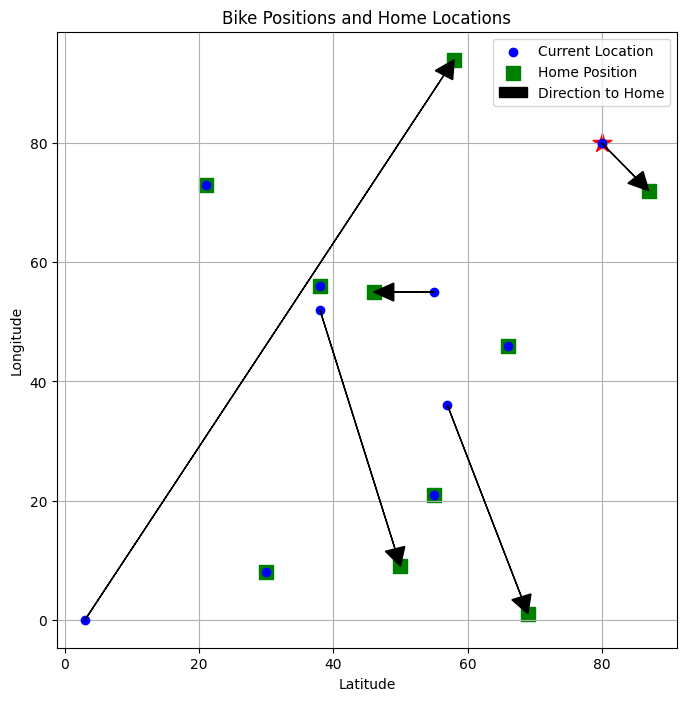

In [33]:
import matplotlib.pyplot as plt

# プロットを作成
plt.figure(figsize=(8, 8))
for index, row in df.iterrows():
    plt.scatter(row['Current Location'][0], row['Current Location'][1], marker='o', color='blue', zorder=2)  # 現在地をプロット
    plt.scatter(row['Home Position'][0], row['Home Position'][1], marker='s', color='green', s=100, zorder=1)  # 自宅位置をプロット
    # 見やすさの観点から矢印の長さを短くしてプロット
    plt.arrow(row['Current Location'][0], row['Current Location'][1],
              row['Home Position'][0] - row['Current Location'][0],
              row['Home Position'][1] - row['Current Location'][1],
              head_width=3, head_length=3, fc='black', ec='black', length_includes_head=True, zorder=3)  # 矢印をプロット

# Userの位置をプロット
plt.scatter(user_position[0], user_position[1], marker='*', color='red', s=200, zorder=1, label='User')

plt.xlabel('Latitude')  # y軸をLatitudeに設定
plt.ylabel('Longitude')  # x軸をLongitudeに設定
plt.title('Bike Positions and Home Locations')
plt.grid(True)
plt.legend(['Current Location', 'Home Position', 'Direction to Home'])
plt.show()
